In [1]:
import numpy as np 
import os
import cv2
import h5py

import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as keras

import matplotlib.pyplot as plt

import tensorflow as tf

2024-03-31 14:50:49.096264: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-31 14:50:49.163748: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-31 14:50:49.164567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 14:50:50.367581: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou


def unet(input_size = (256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(inputs)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv4)
    
    drop4 = Dropout(0.5)(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(pool4)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(conv5)
    
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(drop5))
    
    merge6 = concatenate([drop4,up6])
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge6)
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv6))
    
    merge7 = concatenate([conv3,up7])
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge7)
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'
                                                )(conv7)

    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv7))
    
    merge8 = concatenate([conv2,up8])
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge8)
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',
                                             kernel_initializer = 'he_normal'
                                             )(UpSampling2D(size = (2,2))(conv8))
    
    merge9 = concatenate([conv1,up9])
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(merge9)
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv9)
    
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-3), loss = 'binary_crossentropy', metrics = [dice_coef, iou_coef])

    
    return model

In [3]:
print('*'*30)
print('Loading and preprocessing train data...')
print('*'*30)
file = h5py.File('Dataset_train.h5', 'r')
img_train = file.get('images')
mask_train = file.get('masks')
img_train = np.array(img_train)
mask_train = np.array(mask_train)

img_train = img_train.astype('float32')
img_train /= 255

mask_train = mask_train.astype('float32')
mask_train /= 255  # scale masks to [0, 1]

print('*'*30)
print('Creating and compiling model...')
print('*'*30)
model = unet()

******************************
Loading and preprocessing train data...
******************************
******************************
Creating and compiling model...
******************************


2024-03-31 14:50:58.707044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-31 14:50:59.668230: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-03-31 14:50:59.786151: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18874368 exceeds 10% of free system memory.
2024-03-31 14:50:59.796517: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18874368 exceeds 10% of free sys

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
print('*'*30)
print('Fitting model...')
print('*'*30)

# device = 'gpu' if tf.test.is_gpu_available() else 'cpu'
# model.to(device)

epochs = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(f'weights_bceloss_{epochs}epochs.h5', monitor='val_loss', save_best_only=True)

history =  model.fit(img_train, mask_train, batch_size=4, epochs=epochs, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint, early_stopping])

******************************
Fitting model...
******************************
Epoch 1/5
418/418 [==============================] - ETA: 0s - loss: 2.5626 - dice_coef: 0.2590 - iou_coef: 0.1421

/home/wgt/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


418/418 [==============================] - 2751s 7s/step - loss: 2.5626 - dice_coef: 0.2590 - iou_coef: 0.1421 - val_loss: 0.2241 - val_dice_coef: 0.3347 - val_iou_coef: 0.1709
Epoch 2/5
418/418 [==============================] - 2404s 6s/step - loss: 0.1948 - dice_coef: 0.4929 - iou_coef: 0.3043 - val_loss: 0.1758 - val_dice_coef: 0.4803 - val_iou_coef: 0.2785
Epoch 3/5
418/418 [==============================] - 2342s 6s/step - loss: 0.1621 - dice_coef: 0.5776 - iou_coef: 0.3775 - val_loss: 0.1642 - val_dice_coef: 0.5295 - val_iou_coef: 0.3146
Epoch 4/5
418/418 [==============================] - 2314s 6s/step - loss: 0.1483 - dice_coef: 0.6107 - iou_coef: 0.4141 - val_loss: 0.1618 - val_dice_coef: 0.5482 - val_iou_coef: 0.3395
Epoch 5/5
418/418 [==============================] - 2298s 5s/step - loss: 0.1408 - dice_coef: 0.6320 - iou_coef: 0.4329 - val_loss: 0.1628 - val_dice_coef: 0.5193 - val_iou_coef: 0.3211


In [7]:
file = h5py.File('Dataset_test.h5', 'r')
img_test = file.get('images')
mask_test = file.get('masks')
img_test = np.array(img_test)
mask_test = np.array(mask_test)
img_test = img_test.astype('float32')

img_test /= 255

print('*'*30)
print('Loading saved weights...')
print('*'*30)
#model.load_weights('weights.h5')

print('*'*30)
print('Predicting masks on test data...')
print('*'*30)
mask_pred = model.predict(img_test, verbose=1)

******************************
Loading saved weights...
******************************
******************************
Predicting masks on test data...
******************************
1/1 [==============================] - 5s 5s/step


In [8]:
print('*' * 30)
print('Saving predicted masks to files...')
print('*' * 30)
pred_dir = 'Preds2'
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
for i, image in enumerate(mask_pred):
    image = (image * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(pred_dir, str(i + 1) + '_pred.png'), image)

******************************
Saving predicted masks to files...
******************************


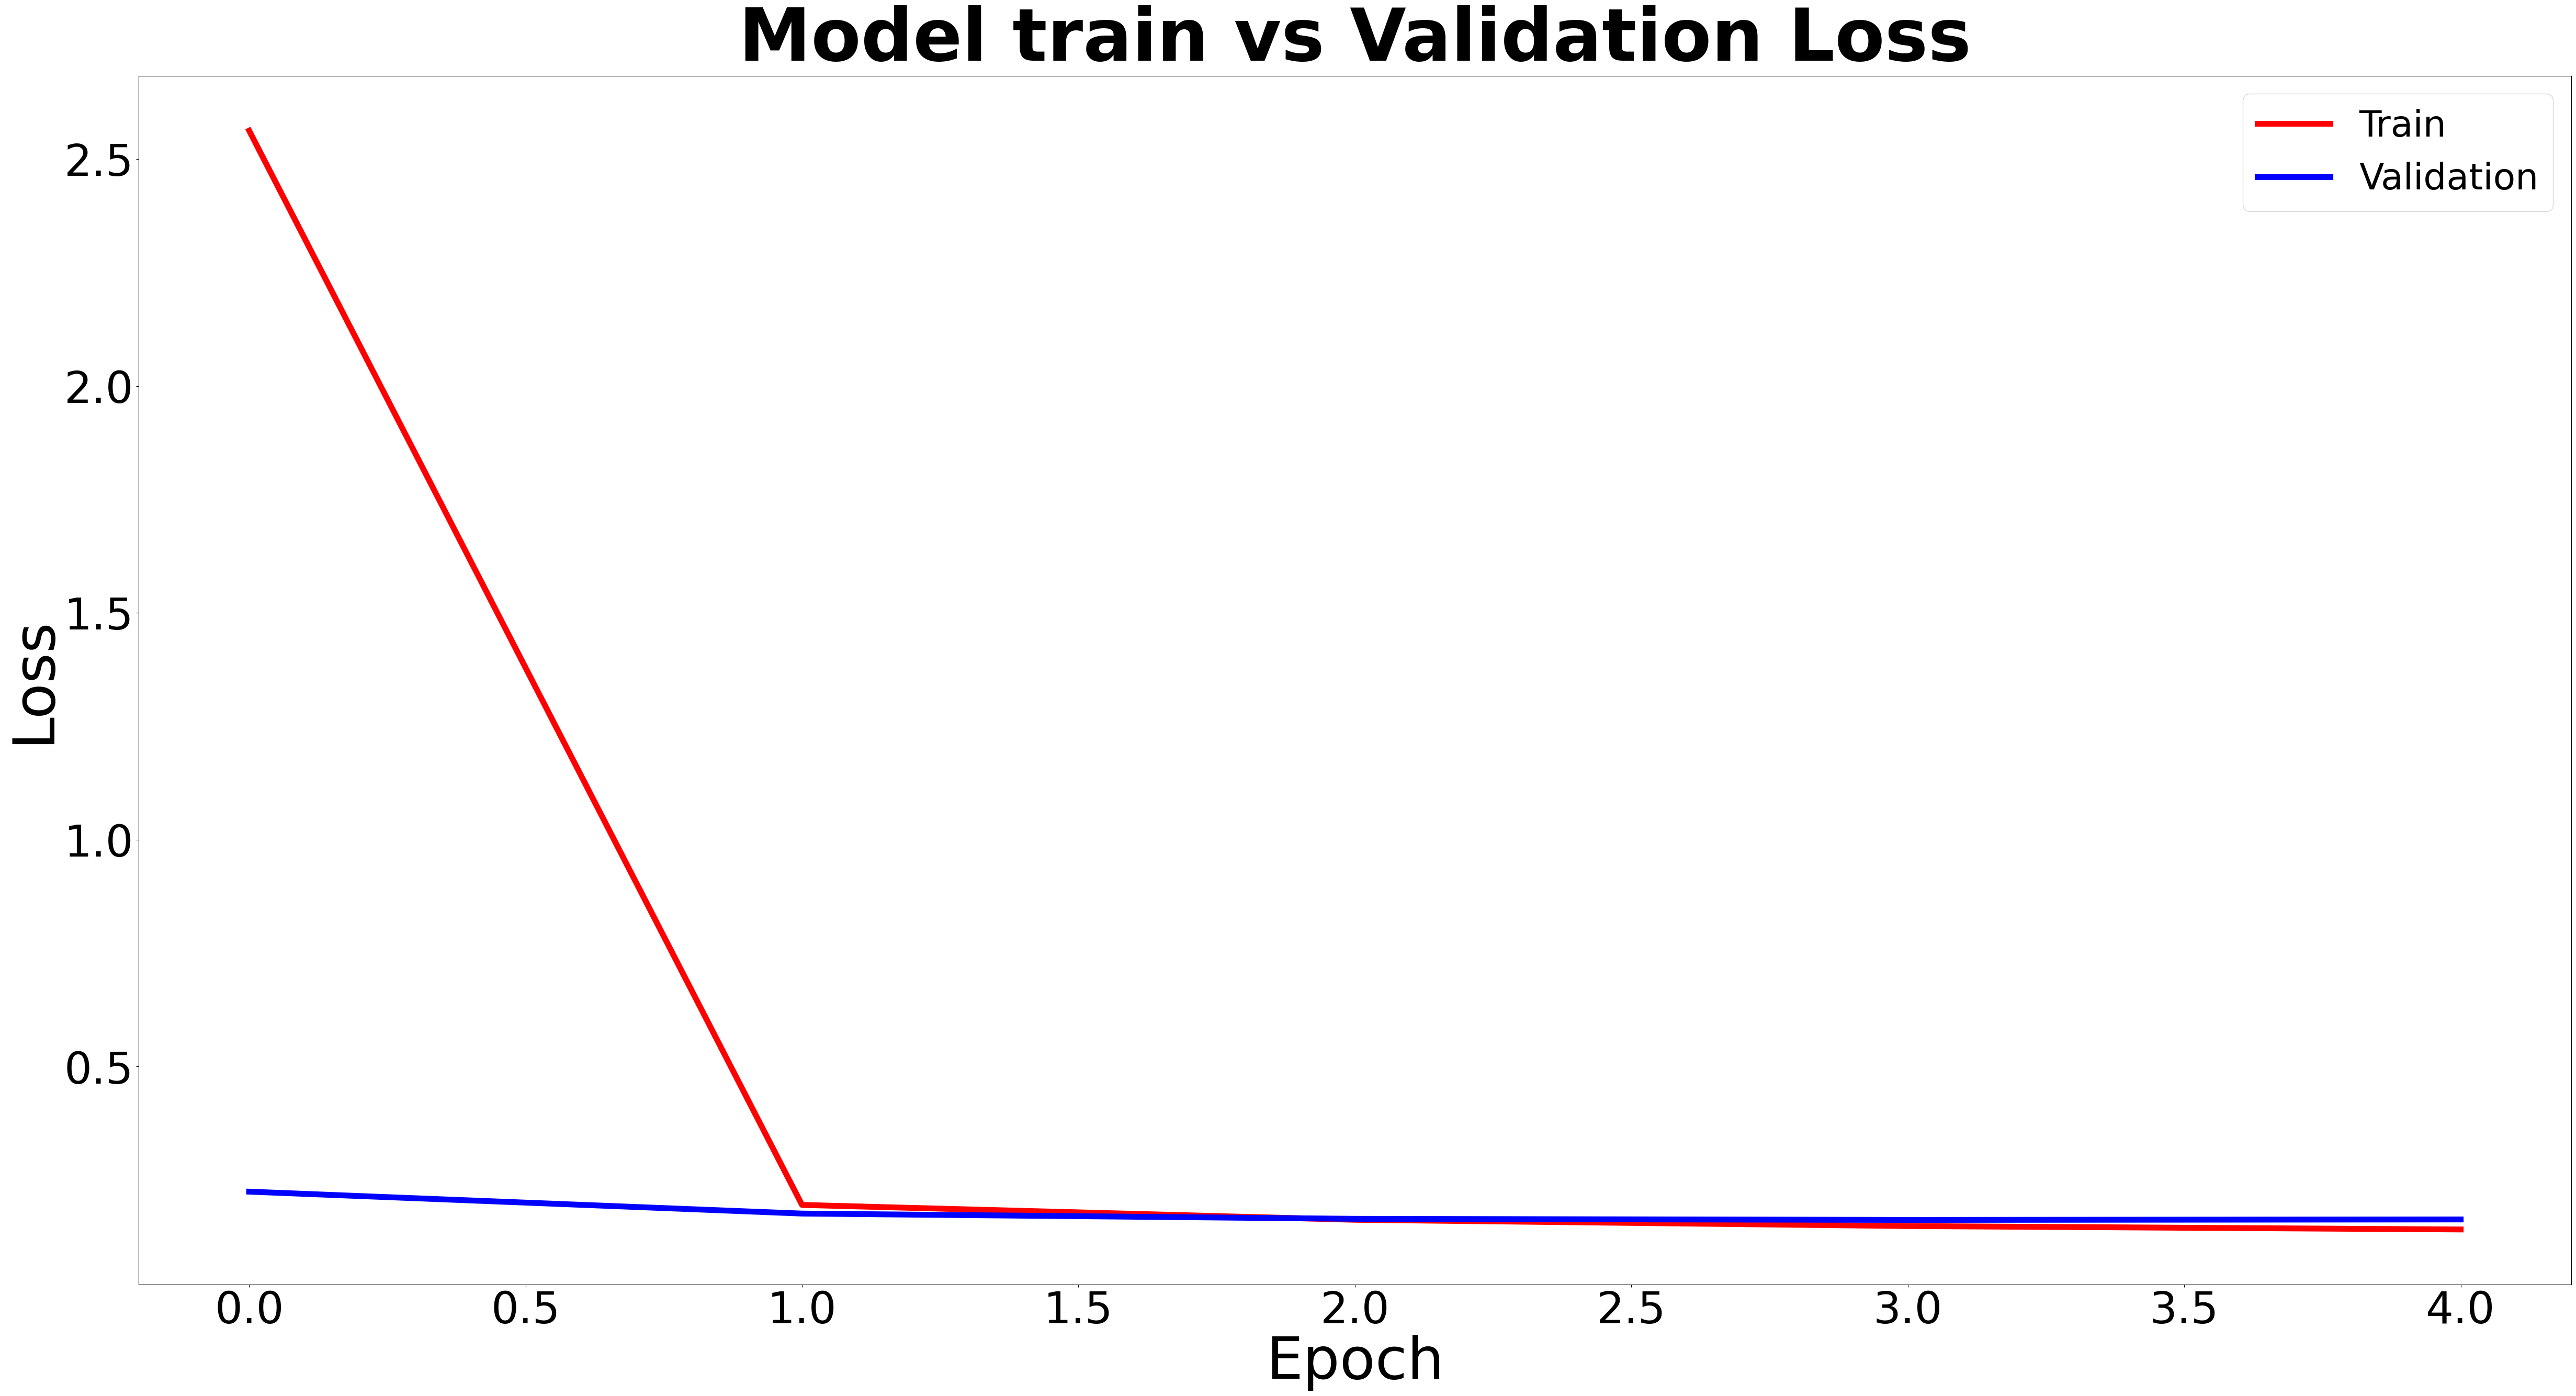

In [9]:
plt.figure(figsize=(60, 30))
plt.plot(history.history['loss'], linewidth=8, color='r')                   #visualising training and validation loss curves
plt.plot(history.history['val_loss'], linewidth=8, color='b')
plt.title('Model train vs Validation Loss', fontsize=100, fontweight="bold")
plt.ylabel('Loss', fontsize=80)
plt.xlabel('Epoch', fontsize=80)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=50)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.show()

In [10]:
# Saving the model weights
model.save_weights('GRID_Unet_Weights.h5')


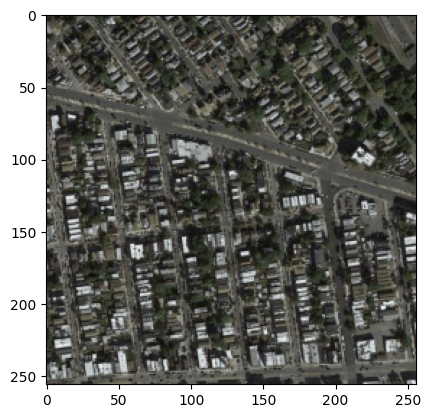

In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Open the .h5 file
file_path = 'Dataset_test.h5'  # Change this to the path of your .h5 file
with h5py.File(file_path, 'r') as file:
    # Assuming the dataset is named 'images', adjust if it has a different name
    images = file['images']  # Or the correct dataset name
    # Convert to NumPy array if necessary
    images = np.array(images)
    
    # Display the first image
    # Adjust the index if you want to see a different image
    plt.imshow(images[2], cmap='gray')  # Use cmap='gray' for grayscale images
    plt.show()

    # Optionally, to display multiple images:
    # for i in range(number_of_images_to_display):
    #     plt.imshow(images[i], cmap='gray')
    #     plt.show()
